## More python to cython

In [9]:
# Change path as needed
MAP_PATH = "../tests/pickle_data/GresvanAIE.xz"

In [10]:
# load cell magic things
%load_ext line_profiler
%load_ext Cython

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The Cython extension is already loaded. To reload it, use:
  %reload_ext Cython


In [11]:
# imports
import matplotlib.pyplot as plt
import numpy as np

from sc2.ids.unit_typeid import UnitTypeId
from sc2.bot_ai import BotAI
from sc2.position import Point2
from sc2.dicts.unit_trained_from import UNIT_TRAINED_FROM
from sc2.data import Race
from sc2.unit import Unit
from sc2.units import Units

from tests.load_bot_from_pickle import get_map_specific_bot

In [12]:
# setup a burnysc2 BOTAI instance we can test with
bot: BotAI = get_map_specific_bot(MAP_PATH)

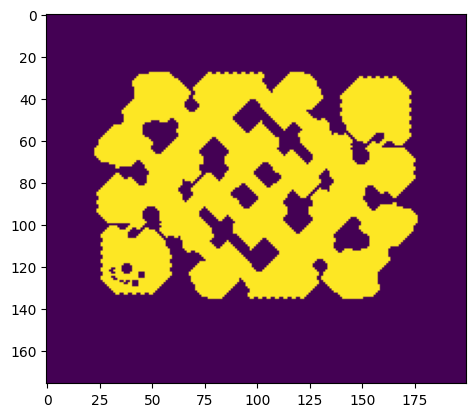

In [5]:
# sanity check that the bot instance is working
plt.imshow(bot.game_info.pathing_grid.data_numpy)

In [13]:
units = bot.units
unit = units[0]


## `has_creep()`

Default function checks pixel map, this is slower then checking a numpy array.

In [7]:
%timeit bot.has_creep(unit)

1.24 μs ± 15.8 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


In [8]:
%timeit bot.has_creep(unit.position)

KeyboardInterrupt: 

In [ ]:
def numpy_has_creep(creep_numpy_grid, position: Point2) -> bool:
    return creep_numpy_grid[position[0], position[1]] == 1

In [ ]:
%timeit numpy_has_creep(bot.state.creep.data_numpy, unit.position.rounded)

#### Already 2.5 times faster! Try cython

In [ ]:
%%cython
from libc.math cimport floor
cimport numpy as cnp
from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
cpdef bint cython_has_creep(
    cnp.ndarray[cnp.npy_bool, ndim=2] creep_numpy_grid,
    (double, double) position,
):
    """Optimized creep checking function with internal rounding"""
    cdef unsigned int x = int(position[0])
    cdef unsigned int y = int(position[1])
    return creep_numpy_grid[x, y] == 1

In [ ]:
%timeit cython_has_creep(bot.state.creep.data_numpy, unit.position)

In [ ]:
# quick test
creep_copy = bot.state.creep.data_numpy.copy()
creep_copy[5, 10] = 1
cython_has_creep(creep_copy, Point2((5.2, 10.2)))

#### Using cython we get ~4.8 times faster over the default burny-sc2 function!

## `in_pathing_grid`

Probably similar to checking `has_creep`

In [ ]:
%timeit bot.in_pathing_grid(unit)

In [ ]:
%timeit bot.in_pathing_grid(unit.position)

In [ ]:
def numpy_in_pathing_grid(pathing_numpy_grid, position: Point2) -> bool:
    return pathing_numpy_grid[position[0], position[1]] == 1

In [ ]:
%timeit numpy_in_pathing_grid(bot.game_info.pathing_grid.data_numpy.T, unit.position.rounded)

In [ ]:
%%cython
from libc.math cimport floor
cimport numpy as cnp
from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
cpdef bint cython_in_pathing_grid(
    cnp.ndarray[cnp.npy_bool, ndim=2] pathing_numpy_grid,
    (double, double) position,
):
    """Optimized creep checking function with internal rounding"""
    cdef unsigned int x = int(position[0])
    cdef unsigned int y = int(position[1])
    return pathing_numpy_grid[x, y] == 1

In [ ]:
%timeit cython_in_pathing_grid(bot.game_info.pathing_grid.data_numpy.T, unit.position)

In [ ]:
%%cython
from libc.math cimport floor
cimport numpy as cnp
from cython cimport boundscheck, wraparound

@boundscheck(False)
@wraparound(False)
cpdef bint cython_in_pathing_grid_ma(
    cnp.ndarray[cnp.float32_t, ndim=2] pathing_numpy_grid,
    (double, double) position,
):
    """Optimized creep checking function with internal rounding"""
    cdef unsigned int x = int(position[0])
    cdef unsigned int y = int(position[1])
    return pathing_numpy_grid[x, y] == 1

In [ ]:
_grid = bot.game_info.pathing_grid.data_numpy.T.astype(np.float32)

In [ ]:
%timeit cython_in_pathing_grid(_grid, unit.position)

#### Using cython we get ~4.4 times faster over the default burny-sc2 function!

In [ ]:
%%cython
from libc.math cimport floor
cimport numpy as cnp
from cython cimport boundscheck, wraparound
import numpy as np

@boundscheck(False)
@wraparound(False)
cpdef bint cy_point_below_value(
    cnp.ndarray[cnp.npy_float32, ndim=2] grid,
    (double, double) position,
    double weight_safety_limit = 1.0,
):
    """
    987 ns ± 10.1 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
    Python alternative:
    4.66 µs ± 64.8 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)
    """
    cdef double weight = 0.0
    cdef unsigned int x = int(position[0])
    cdef unsigned int y = int(position[1])
    weight = grid[x, y]
    # np.inf check if drone is pathing near a spore crawler
    return weight == np.inf or weight <= weight_safety_limit

In [ ]:
grid = bot.game_info.pathing_grid.data_numpy.T.astype(np.float32)

In [ ]:
%timeit cy_point_below_value(grid, Point2((5, 10)))


In [ ]:
%timeit cy_point_below_value(grid, Point2((5, 10)))

## `cy_closer_than()`


### Python Version:

In [14]:
%timeit units.closer_than(10.0, unit.position)

12.9 μs ± 80.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [15]:
%%cython
from cython cimport boundscheck, wraparound

cpdef double cy_distance_to_squared(
        (double, double) p1,
        (double, double) p2
):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2


@boundscheck(False)
@wraparound(False)
cpdef (list) cy_closer_than(object units, double max_distance, (float, float) position ):
    cdef:
        unsigned int len_units = len(units)
        unsigned int i
        double max_distance_sq = max_distance * max_distance
        double dist_sq
        (float, float) other_pos
        list returned_units = []

    for i in range(len_units):
        other_pos = units[i].position
        dist_sq = cy_distance_to_squared((other_pos[0], other_pos[1]), (position[0], position[1]))
        if dist_sq < max_distance_sq:
            returned_units.append(units[i])

    return returned_units

Content of stdout:
_cython_magic_a20e46a6b786b8d1c1ddfa29bf2a730ba8be1fb882e79351f1bf7059db48fde2.c
C:\Users\jonas\.ipython\cython\_cython_magic_a20e46a6b786b8d1c1ddfa29bf2a730ba8be1fb882e79351f1bf7059db48fde2.c(2619): warning C4244: "=": Konvertierung von "Py_ssize_t" in "unsigned int", m”glicher Datenverlust
   Bibliothek "C:\Users\jonas\.ipython\cython\Users\jonas\.ipython\cython\_cython_magic_a20e46a6b786b8d1c1ddfa29bf2a730ba8be1fb882e79351f1bf7059db48fde2.cp313-win_amd64.lib" und Objekt "C:\Users\jonas\.ipython\cython\Users\jonas\.ipython\cython\_cython_magic_a20e46a6b786b8d1c1ddfa29bf2a730ba8be1fb882e79351f1bf7059db48fde2.cp313-win_amd64.exp" werden erstellt.
Code wird generiert.
Codegenerierung ist abgeschlossen.

### Cython Version:

In [16]:
%timeit cy_closer_than(units, 10.0, unit.position)

1.39 μs ± 3.76 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)


### Python Hybrid version of `units.closer_than()` that uses a cython distance calculation.


In [22]:
from cython_extensions import cy_distance_to_squared, enable_safe_mode
enable_safe_mode(False)
def alternative_hybrid(units, position, distance):
    max_sq = distance * distance
    return [u for u in units
            if cy_distance_to_squared(u.position, position) < max_sq]
    

In [24]:
%timeit alternative_hybrid(units, unit.position, 10.0)

7.2 μs ± 24.2 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


## `cy_further_than()`

### Python:

In [25]:
%timeit units.further_than(10.0, unit.position)

12.8 μs ± 28.9 ns per loop (mean ± std. dev. of 7 runs, 100,000 loops each)


In [26]:
%%cython
from cython cimport boundscheck, wraparound

cpdef double cy_distance_to_squared(
        (double, double) p1,
        (double, double) p2
):
    return (p1[0] - p2[0]) ** 2 + (p1[1] - p2[1]) ** 2


@boundscheck(False)
@wraparound(False)

@boundscheck(False)
@wraparound(False)
cpdef (list) cy_further_than(object units, double min_distance, (float, float) position ):
    cdef:
        unsigned int len_units = len(units)
        unsigned int i
        double min_distance_sq = min_distance * min_distance
        double dist_sq
        (float, float) other_pos
        list returned_units = []

    for i in range(len_units):
        other_pos = units[i].position
        dist_sq = cy_distance_to_squared((other_pos[0], other_pos[1]), (position[0], position[1]))
        if dist_sq > min_distance_sq:
            returned_units.append(units[i])

    return returned_units

Content of stdout:
_cython_magic_523af4b6ee4aace633c25dd9acd381a30e9136ee3692c6c17d68cca424884505.c
C:\Users\jonas\.ipython\cython\_cython_magic_523af4b6ee4aace633c25dd9acd381a30e9136ee3692c6c17d68cca424884505.c(2619): warning C4244: "=": Konvertierung von "Py_ssize_t" in "unsigned int", m”glicher Datenverlust
   Bibliothek "C:\Users\jonas\.ipython\cython\Users\jonas\.ipython\cython\_cython_magic_523af4b6ee4aace633c25dd9acd381a30e9136ee3692c6c17d68cca424884505.cp313-win_amd64.lib" und Objekt "C:\Users\jonas\.ipython\cython\Users\jonas\.ipython\cython\_cython_magic_523af4b6ee4aace633c25dd9acd381a30e9136ee3692c6c17d68cca424884505.cp313-win_amd64.exp" werden erstellt.
Code wird generiert.
Codegenerierung ist abgeschlossen.

### Cython:

In [27]:
%timeit cy_further_than(units, 10.0, unit.position)

1.04 μs ± 5.12 ns per loop (mean ± std. dev. of 7 runs, 1,000,000 loops each)
